In [1]:
from subprocess import call
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
import shutil
import sys
import time
%config Completer.use_jedi = False

D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\__init__.py:143: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "D:\Anaconda3\envs\odor-states\python.exe"
  * The NumPy version is: "1.20.1"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


In [19]:
sys.argv = ["python","2","13674","1"]
if not os.path.exists(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}"):
    os.makedirs(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}")
else:
    shutil.rmtree(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}")
    os.makedirs(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}")

In [20]:
n_n = 120             # number of neurons
p_n = 90                  # number of PNs
l_n = 30                  # number of LNs

pPNPN = 0.0
pPNLN = 0.1
pLNPN = 0.2

ach_mat = np.zeros((n_n,n_n))
np.random.seed(64163+int(sys.argv[1]))
ach_mat[p_n:,:p_n] = np.random.choice([0.,1.],size=(l_n,p_n),p=(1-pPNLN,pPNLN))
ach_mat[:p_n,:p_n] = np.random.choice([0.,1.],size=(p_n,p_n),p=(1-pPNPN,pPNPN))
n_syn_ach = int(np.sum(ach_mat))

LNPN = np.zeros((p_n,l_n))
stride = int(p_n/l_n)
spread = (round(pLNPN*p_n)//2)*2+1 # Round to closest odd integer
center = 0
index = np.arange(p_n)
for i in range(l_n):
    idx = index[np.arange(center-spread//2,1+center+spread//2)%p_n]
    LNPN[idx,i] = 1
    center+=stride

fgaba_mat = np.zeros((n_n,n_n))
fgaba_mat[:p_n,p_n:] = LNPN # LN->PN
fgaba_mat[p_n:,p_n:] = np.loadtxt(f'../modules/networks/matrix_{sys.argv[1]}.csv',delimiter=',') # LN->LN
np.fill_diagonal(fgaba_mat,0.)
n_syn_fgaba = int(np.sum(fgaba_mat))

sgaba_mat = np.zeros((n_n,n_n))
sgaba_mat[:p_n,p_n:] = LNPN
np.fill_diagonal(sgaba_mat,0.)
n_syn_sgaba = int(np.sum(sgaba_mat))

In [21]:
blocktime = 12000 # in ms
buffer = 500 # in ms
sim_res = 0.01 # in ms
min_block = 50 # in ms

In [22]:
np.random.seed(int(sys.argv[1])+int(sys.argv[2])+int(sys.argv[3]))
sw_state = [0]
switch_prob = 0.3
for i in np.random.choice([0,1],p=[1-switch_prob,switch_prob],size=int(blocktime/min_block)-1):
    if i==1:
        sw_state.append(1-sw_state[-1])
    else:
        sw_state.append(sw_state[-1])
ts = np.repeat(sw_state,int(min_block/sim_res))

In [23]:
sim_time = blocktime + 2*buffer
t = np.arange(0,sim_time,sim_res)
current_input = np.ones((n_n,t.shape[0]-int(2*buffer/sim_res)))
np.random.seed(int(sys.argv[2]))
set_pn = np.random.choice([0,1],p=[0.9,0.1],size=90)
current_input[:p_n,:] = 0.20*(current_input[:p_n,:].T*set_pn).T*ts
current_input[p_n:,:] = 0.0735*current_input[p_n:,:]*ts
current_input = np.concatenate([np.zeros((current_input.shape[0],int(buffer/sim_res))),current_input,np.zeros((current_input.shape[0],int(buffer/sim_res)))],axis=1)
np.random.seed()
current_input += 0.05*current_input*np.random.normal(size=current_input.shape)+ 0.001*np.random.normal(size=current_input.shape)

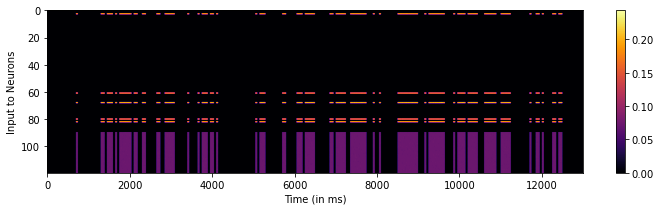

In [24]:
plt.figure(figsize=(12,3))
plt.imshow(current_input[:,::100],aspect='auto',vmin=0,cmap=plt.cm.inferno)
plt.xlabel('Time (in ms)')
plt.ylabel('Input to Neurons')
plt.colorbar()

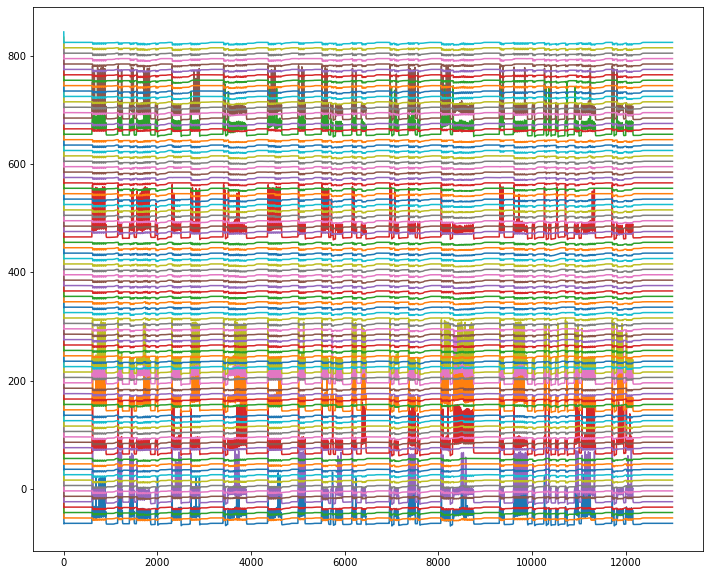

In [4]:
plt.figure(figsize=(12,10))
for i in range(90):
    plt.plot(i*10+np.load("Data/data_2_13674_10.npy")[:,i])

50it [00:00, 84.20it/s]


(array([ 0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.]),
 array([8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5]),
 <BarContainer object of 10 artists>)

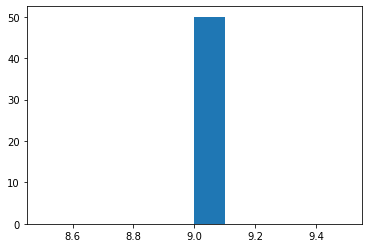

In [10]:
activepn = []
for i in tqdm(filter(lambda v: ".npy" in v,os.listdir('Data'))):
    temp = np.load(f"Data/{i}").T
# plt.plot(np.logical_and(temp[:90,1:]>=0,temp[:90,:-1]<0).mean(axis=1))
    activepn.append((np.logical_and(temp[:90,1:]>=0,temp[:90,:-1]<0).mean(axis=1)>0).sum())
plt.hist(activepn)

50it [00:00, 51.58it/s]


(array([9109., 2363., 1803.,  298., 3452., 8783., 2966.,  554.,  858.,
        2687.]),
 array([ 0.43994721,  5.39595249, 10.35195777, 15.30796304, 20.26396832,
        25.2199736 , 30.17597888, 35.13198416, 40.08798944, 45.04399472,
        50.        ]),
 <BarContainer object of 10 artists>)

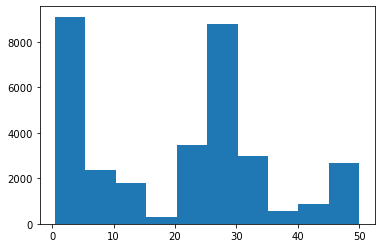

In [28]:
activepn = []
for i in tqdm(filter(lambda v: ".npy" in v,os.listdir('Data'))):
    temp = np.load(f"Data/{i}").T
# plt.plot(np.logical_and(temp[:90,1:]>=0,temp[:90,:-1]<0).mean(axis=1))
    spikes = np.logical_and(temp[:90,1:]>=0,temp[:90,:-1]<0)
    temp = np.concatenate([1/np.diff(np.linspace(0,12.998,12999)[i>0]) for i in spikes])
    activepn.append(temp)
plt.hist(np.concatenate(activepn))

In [21]:
activepn[0]

IndexError: list index out of range

In [4]:
data = []
time = np.linspace(0,12.998,12999)
for i in tqdm(range(10)):
    temp = np.load(f"Data/data_2_72957_{i+1}.npy")
    pn_temp = np.logical_and(temp[:-1,:90]<0,temp[1:,:90]>0)
    ln_temp = np.logical_and(temp[:-1,90:]<-20,temp[1:,90:]>-20)
    pn_firing = []
    ln_firing = []
    for j in range(90):
        pn_firing.append(time[pn_temp[:,j]])
    for j in range(30):
        ln_firing.append(time[ln_temp[:,j]])
    data.append((pn_firing,ln_firing,temp))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.77it/s]


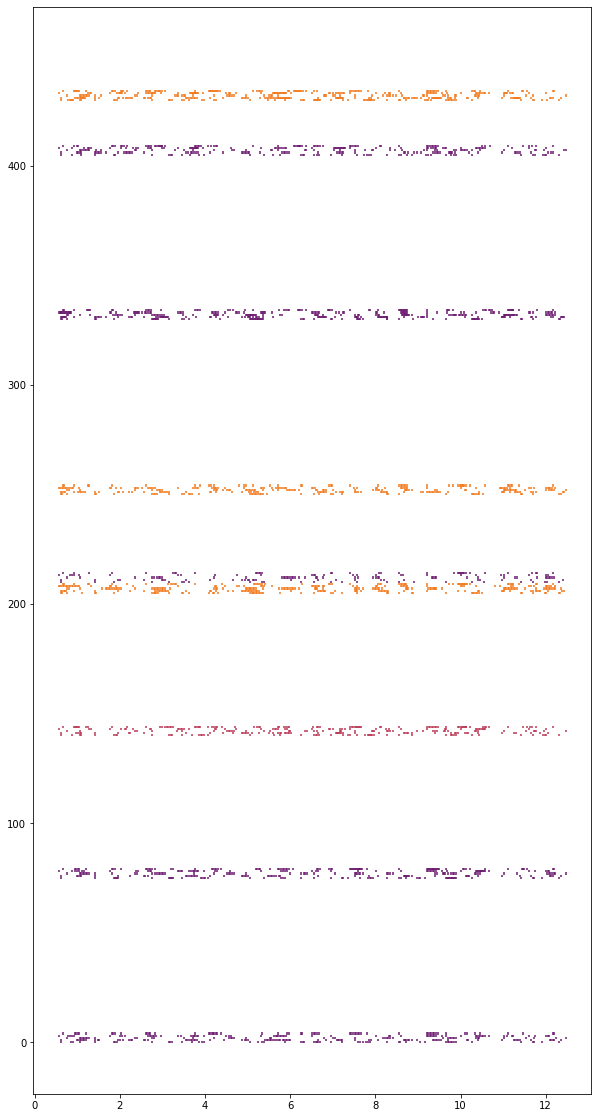

In [5]:
rep = 5
plt.figure(figsize=(10,20))
events = []
colors = []
for i in range(90):
    for j in range(rep):
        events.append(data[j][0][i])
colors = ([plt.cm.inferno(0.3)]*rep+[plt.cm.inferno(0.5)]*rep+[plt.cm.inferno(0.7)]*rep)*30
plt.eventplot(events,colors=colors)
plt.show()

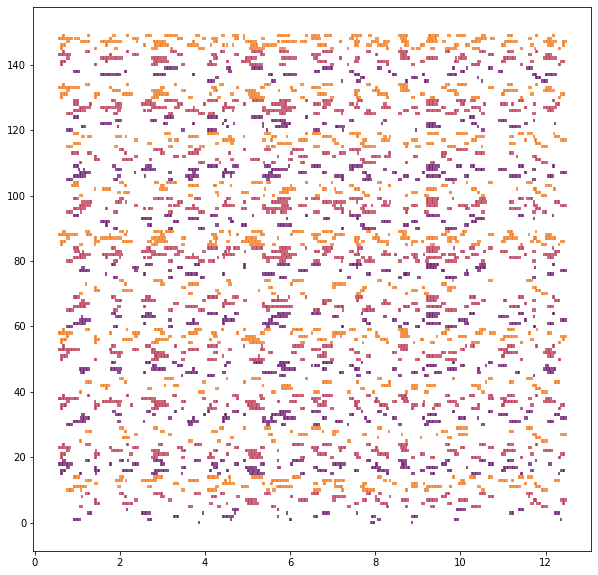

In [6]:
rep = 5
plt.figure(figsize=(10,10))
events = []
colors = []
for i in range(30):
    for j in range(rep):
        events.append(data[j][1][i])
colors = ([plt.cm.inferno(0.3)]*rep+[plt.cm.inferno(0.5)]*rep+[plt.cm.inferno(0.7)]*rep)*10
plt.eventplot(events,colors=colors)
plt.show()

In [2]:
from neo.core import SpikeTrain
import quantities as q
import elephant as eph
from scipy.stats import pearsonr
r = []
mat = np.loadtxt(f'../modules/networks/matrix_2.csv',delimiter=",")
module = np.loadtxt(f'../modules/networks/matrix_2_modules.csv')
order = np.argsort(module)
for i in tqdm(filter(lambda v: ".npy" in v,os.listdir('Data'))):
    temp = np.load(f"Data/{i}").T
# plt.plot(np.logical_and(temp[:90,1:]>=0,temp[:90,:-1]<0).mean(axis=1))
    spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
    event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[i>0]*q.s,t_stop=13*q.s) for i in spikes])
    bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
    pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
    r.append(pearson_correlation)

0it [00:00, ?it/s]<ipython-input-2-acc2658f64dd>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[i>0]*q.s,t_stop=13*q.s) for i in spikes])
50it [00:24,  2.05it/s]


In [3]:
corr_mat = np.ones((50,50))
for i in range(50):
    for j in range(i):
        corr_mat[i,j] = pearsonr(r[i].flatten(),r[j].flatten())[0]
        corr_mat[j,i] = corr_mat[i,j]

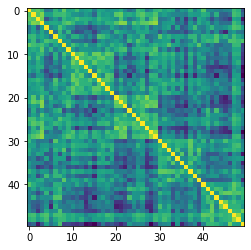

In [4]:
plt.imshow(corr_mat)

In [5]:
mat.shape

(30, 30)

In [6]:
import seaborn as sns

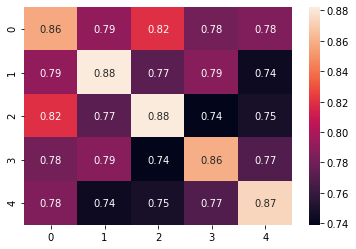

In [7]:
summary_matrix = np.zeros((5,5))
within = []
across = []
for i in range(5):
    for j in range(i+1):
        temp = corr_mat[10*i:10*i+10,10*j:10*j+10]
        if i==j:
            summary_matrix[i,j] = np.mean(temp[np.tril_indices(10,-1)])
            within.append(temp[np.tril_indices(10,-1)].flatten())
        else:
            summary_matrix[i,j] = np.mean(temp)
            across.append(temp.flatten())
        summary_matrix[j,i] = summary_matrix[i,j]
sns.heatmap(summary_matrix,annot=True)
within = np.concatenate(within)
across = np.concatenate(across)

In [8]:
from scipy.stats import ttest_ind,kruskal
ttest_ind(within[within!=1],across) ,kruskal(within[within!=1],across)

(Ttest_indResult(statistic=15.256881514781655, pvalue=3.0477853473204255e-48),
 KruskalResult(statistic=211.42713322457803, pvalue=6.706727943194062e-48))

In [17]:
ttest_ind(summary_matrix[np.diag_indices(5)],summary_matrix[np.tril_indices(5,-1)]) ,kruskal(summary_matrix[np.diag_indices(5)],summary_matrix[np.tril_indices(5,-1)])

(Ttest_indResult(statistic=8.136396208019494, pvalue=1.8574158337779957e-06),
 KruskalResult(statistic=9.375, pvalue=0.00219964706111306))

<AxesSubplot:>

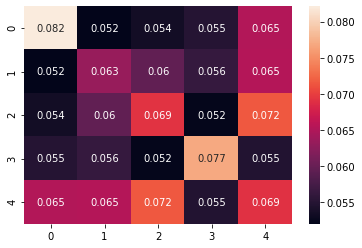

In [59]:
summary_matrix = np.zeros((5,5))
for i in range(5):
    for j in range(i+1):
        temp = corr_mat[10*i:10*i+10,10*j:10*j+10]
        if i==j:
            summary_matrix[i,j] = np.std(temp[np.tril_indices(10)])
        else:
            summary_matrix[i,j] = np.std(temp)
        summary_matrix[j,i] = summary_matrix[i,j]
sns.heatmap(summary_matrix,annot=True)


In [6]:
missed = np.loadtxt('missed.txt',dtype=str)[:,[4,8]]

In [7]:
for n,i in enumerate(missed[np.int32(missed[:,0])<np.max(np.int32(missed[:,0])),1]):
    if n%10==0:
        print(f"#Set {n//10}")
    _,net,odor,rep,_ = re.split('\.|_',i)
    print(f"srun -lN1 -r{n%10} init_pert_trial.sh '{net}' '{odor}' '{rep}' &")

#Set 0
srun -lN1 -r0 init_pert_trial.sh '10' '13674' '10' &
srun -lN1 -r1 init_pert_trial.sh '10' '13674' '1' &
srun -lN1 -r2 init_pert_trial.sh '10' '13674' '2' &
srun -lN1 -r3 init_pert_trial.sh '10' '13674' '4' &
srun -lN1 -r4 init_pert_trial.sh '10' '13674' '6' &
srun -lN1 -r5 init_pert_trial.sh '10' '13674' '7' &
srun -lN1 -r6 init_pert_trial.sh '10' '13674' '8' &
srun -lN1 -r7 init_pert_trial.sh '10' '13674' '9' &
srun -lN1 -r8 init_pert_trial.sh '10' '59428' '10' &
srun -lN1 -r9 init_pert_trial.sh '10' '59428' '1' &
#Set 1
srun -lN1 -r0 init_pert_trial.sh '2' '59428' '5' &
srun -lN1 -r1 init_pert_trial.sh '9' '84932' '4' &
srun -lN1 -r2 init_pert_trial.sh '9' '84932' '5' &
srun -lN1 -r3 init_pert_trial.sh '9' '84932' '9' &
srun -lN1 -r4 init_pert_trial.sh '9' '85036' '3' &
srun -lN1 -r5 init_pert_trial.sh '9' '85036' '4' &
srun -lN1 -r6 init_pert_trial.sh '9' '85036' '9' &


In [91]:
p=0.1
odors = []
for i in tqdm(range(1000)):
    setpn = np.concatenate([np.ones(9),np.zeros(81)])
    np.random.shuffle(setpn)
    mat = np.random.choice([0,1],p=[1-p,p],size=(30,90))
    odors.append(np.matmul(mat,setpn.reshape(-1,1)).flatten())

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8762.41it/s]


In [94]:
overlap = []
for i in tqdm(range(1000)):
    for j in range(i):
        overlap.append(np.logical_and(odors[i],odors[j]).mean())

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.09it/s]


In [95]:
np.mean(overlap)

0.37091524858191527